# Preparation

## Starting the timer

In [1]:
import time

start_time = time.time()

## Importing and setting global variables

In [2]:
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

import imblearn
from imblearn.over_sampling import SMOTE

In [3]:
CSV_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/AppStats Project/data.csv'

TEST_TO_ALL_SIZE = 0.125
VAL_TO_TRAIN_SIZE = 0.1

RSPL_TO_OVER_SIZE = 2

RANDOM_STATE = 42

## Setting up

In [4]:
np.random.seed(RANDOM_STATE)

In [5]:
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [6]:
def plot_mean_test_score(iter_index, params, mean_test_score):
    plt.scatter(params, mean_test_score, s=10)

In [7]:
def get_params_from_list_of_dict(param_name, l):
    return [d[param_name] for d in l]

In [8]:
def show_cv_results(param_name, cv_results):
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.xlabel(param_name)
    plt.ylabel('Mean test score')

    params = get_params_from_list_of_dict(param_name, cv_results['params'])
    df = pd.DataFrame({'iter': cv_results['iter'],
                       param_name: params,
                       'mean_test_score': cv_results['mean_test_score'],
                       'rank_test_score': cv_results['rank_test_score']
                       })
    
    for iter_index in np.unique(cv_results['iter']):
        df_sub = df[df['iter'] == iter_index]
        plot_mean_test_score(
            iter_index, df_sub[param_name], df_sub['mean_test_score'])
    return df

    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

# Data preparation

## Data exploration

In [9]:
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [10]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


## Splitting the dataset into training set, validation set, and test set

In [11]:
y = (df['Bankrupt?']).to_numpy()
y

array([1, 1, 1, ..., 0, 0, 0])

In [12]:
X = df.drop('Bankrupt?', axis=1, inplace=False).to_numpy()
X

array([[0.37059426, 0.42438945, 0.40574977, ..., 0.56405011, 1.        ,
        0.01646874],
       [0.46429094, 0.53821413, 0.51673002, ..., 0.57017495, 1.        ,
        0.02079431],
       [0.42607127, 0.49901875, 0.47229509, ..., 0.56370608, 1.        ,
        0.01647411],
       ...,
       [0.47272461, 0.533744  , 0.52063815, ..., 0.5651584 , 1.        ,
        0.09764874],
       [0.50626432, 0.5599106 , 0.55404465, ..., 0.56530151, 1.        ,
        0.04400945],
       [0.49305319, 0.57010467, 0.54954762, ..., 0.56516694, 1.        ,
        0.23390224]])

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=TEST_TO_ALL_SIZE, stratify=y,
        random_state=RANDOM_STATE)
print(  X_train_val.shape,
        X_test.shape,
        X_train_val.shape,
        y_test.shape
)

(5966, 95) (853, 95) (5966, 95) (853,)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=VAL_TO_TRAIN_SIZE,
        stratify=y_train_val,
        random_state=RANDOM_STATE)
print(  X_train.shape,
        X_val.shape,
        y_train.shape,
        y_val.shape
)

(5369, 95) (597, 95) (5369,) (597,)


(array([0, 1]), array([6599,  220]))
(array([0, 1]), array([5196,  173]))
(array([0, 1]), array([578,  19]))
(array([0, 1]), array([825,  28]))


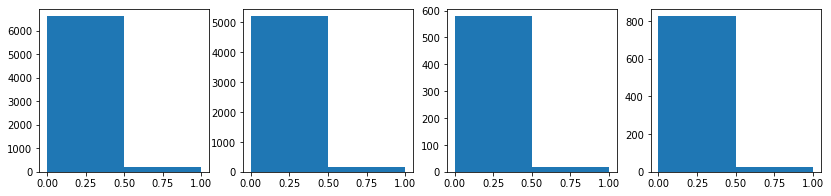

In [15]:
fig, ax = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(14)

ax[0].hist(y, bins=2)
ax[1].hist(y_train, bins=2)
ax[2].hist(y_val, bins=2)
ax[3].hist(y_test, bins=2)

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test, return_counts=True))

## Creating a new dataset that SMOTE oversample the training set

In [16]:
X_train_over, y_train_over = SMOTE(
    random_state=RANDOM_STATE).fit_resample(X_train, y_train)

(array([0, 1]), array([5196, 5196]))


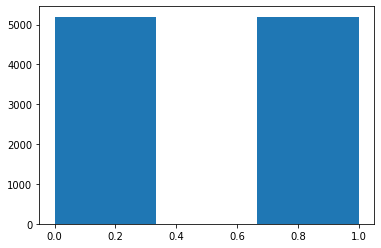

In [17]:
plt.hist(y_train_over, bins=3)
print(np.unique(y_train_over, return_counts=True))

## Creating a new dataset that SMOTE oversample the training and validation set

In [18]:
X_train_val_over, y_train_val_over = SMOTE(
    random_state=RANDOM_STATE).fit_resample(X_train_val, y_train_val)

(array([0, 1]), array([5774, 5774]))


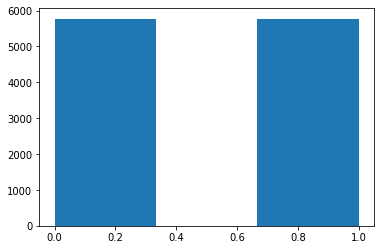

In [19]:
plt.hist(y_train_val_over, bins=3)
print(np.unique(y_train_val_over, return_counts=True))

# Random forest

## Setting up parameter grid and Random forest

In [20]:
n_estimators_rf = np.arange(50, 201, dtype=int)
n_estimators_rf

array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200])

In [21]:
param_grid_rf = {'n_estimators': n_estimators_rf}

In [22]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf

RandomForestClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [23]:
clf_rf = HalvingGridSearchCV(rf, param_grid_rf, scoring=f2_scorer, 
                               random_state=RANDOM_STATE, cv=3)
clf_rf

HalvingGridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122...
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200])},
                    random_state=42, scoring=make_scorer

In [24]:
clf_rf.fit(X_train_over, y_train_over)

HalvingGridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122...
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200])},
                    random_state=42, scoring=make_scorer

In [25]:
clf_rf.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 4, 4]),
 'mean_fit_time': array([ 0.14365379,  0.16653371,  0.1460433 ,  0.18566855,  0.13461947,
         0.16135017,  0.18307026,  0.1726191 ,  0.18257697,  0.20034361,
         0.18824458,  0.17464892,  0.19685912,  0.20560257

,iter,n_estimators,mean_test_score,rank_test_score
0,0,50,0.852495,187
1,0,51,0.852495,187
2,0,52,0.852495,187
3,0,53,0.852495,187
4,0,54,0.852495,187
...,...,...,...,...
222,3,157,0.964310,4
223,3,149,0.963345,8
224,3,169,0.963965,5
225,4,157,0.988029,1


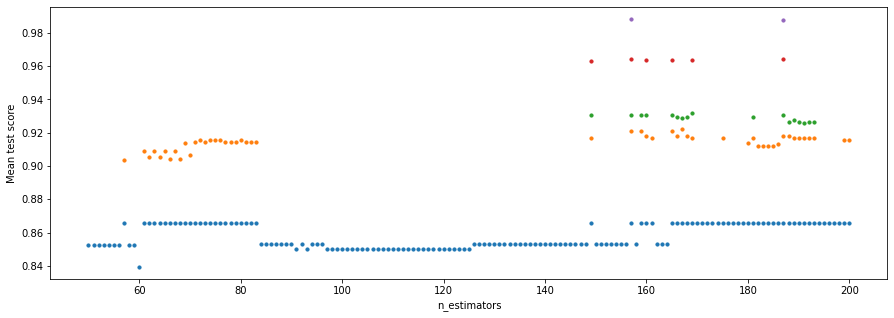

In [26]:
show_cv_results('n_estimators', clf_rf.cv_results_)

In [27]:
best_rf = clf_rf.best_estimator_
best_rf

RandomForestClassifier(n_estimators=157, random_state=42)

In [28]:
y_val_pred_best_rf = best_rf.predict(X_val)
f2_score(y_val, y_val_pred_best_rf)

0.6862745098039215

In [29]:
best_rf.feature_importances_

array([0.01862026, 0.03020667, 0.02505078, 0.00365536, 0.00357177,
       0.01004923, 0.02502298, 0.05430697, 0.01377716, 0.03491197,
       0.0035351 , 0.00314161, 0.00300699, 0.00886403, 0.00245806,
       0.00503899, 0.00843891, 0.00793887, 0.05024937, 0.0031459 ,
       0.00365134, 0.00428008, 0.03161663, 0.00265778, 0.00295246,
       0.00509644, 0.00425495, 0.00393679, 0.0058943 , 0.01888417,
       0.00268771, 0.00262984, 0.00245653, 0.00898183, 0.0107566 ,
       0.05172119, 0.02041576, 0.01951123, 0.00246444, 0.02546082,
       0.00427747, 0.00852287, 0.03407256, 0.00281954, 0.00343692,
       0.00368019, 0.00530178, 0.00433191, 0.00583851, 0.00259647,
       0.00568187, 0.00404241, 0.0081111 , 0.00235277, 0.00334439,
       0.00307103, 0.0042536 , 0.00437451, 0.00305103, 0.00623993,
       0.00483375, 0.00890061, 0.0036752 , 0.00516508, 0.00277397,
       0.01148774, 0.00585817, 0.03540003, 0.03749784, 0.00357154,
       0.00604843, 0.00668659, 0.00229488, 0.00808419, 0.00331

# Bagging

## Setting up parameter grid and Bagging

In [30]:
n_estimators_bagging = np.arange(5, 21, dtype=int)
n_estimators_bagging

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [31]:
param_grid_bagging = {'n_estimators': n_estimators_bagging}

In [32]:
bagging = BaggingClassifier(random_state=RANDOM_STATE)
bagging

BaggingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [33]:
clf_bagging = HalvingGridSearchCV(bagging, param_grid_bagging,
                                  scoring=f2_scorer,
                                  random_state=RANDOM_STATE,
                                  cv=3)
clf_bagging

HalvingGridSearchCV(cv=3, estimator=BaggingClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [34]:
clf_bagging.fit(X_train_over, y_train_over)

HalvingGridSearchCV(cv=3, estimator=BaggingClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [35]:
clf_bagging.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        2, 2]),
 'mean_fit_time': array([ 0.17365623,  0.21303034,  0.24883723,  0.28430653,  0.31895065,
         0.35876759,  0.38453778,  0.42276112,  0.46023687,  0.49526604,
         0.52947776,  0.55557156,  0.6093212 ,  0.64201323,  0.66733638,
         0.70633944,  1.88315701,  2.20035156,  2.86920206,  3.03078763,
         3.36417484,  3.19416006, 14.26394526, 15.97015953]),
 'mean_score_time': array([0.00334589, 0.00472252, 0.00514237, 0.0048519 , 0.00509961,
        0.00543793, 0.00508444, 0.00543157, 0.0057079 , 0.00653156,
        0.00643436, 0.00641831, 0.00733256, 0.00777284, 0.00763075,
        0.00763265, 0.01080966, 0.01205095, 0.01744167, 0.01654164,
        0.01704558, 0.01658249, 0.03845255, 0.03911122]),
 'mean_test_score': array([0.90762556, 0.89152589, 0.91364113, 0.89705196, 0.9139064 ,
        0.90553933, 0.91683444, 0.90658275, 0.91918375, 0.91273747,
        0.91677024, 0.91613

,iter,n_estimators,mean_test_score,rank_test_score
0,0,5,0.907626,20
1,0,6,0.891526,24
2,0,7,0.913641,18
3,0,8,0.897052,23
4,0,9,0.913906,17
5,0,10,0.905539,22
6,0,11,0.916834,14
7,0,12,0.906583,21
8,0,13,0.919184,13
9,0,14,0.912737,19


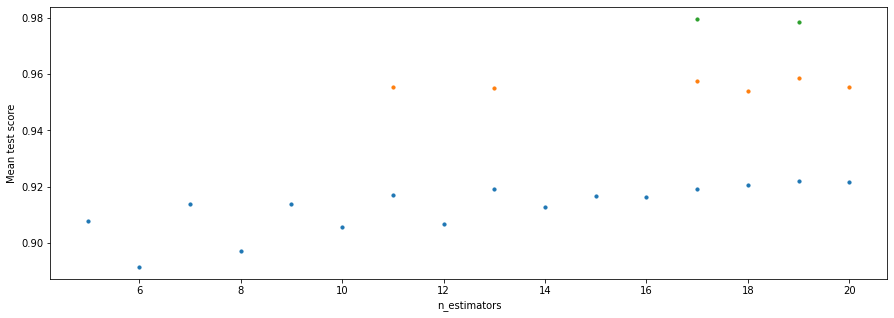

In [36]:
show_cv_results('n_estimators', clf_bagging.cv_results_)

In [37]:
best_bagging = clf_bagging.best_estimator_
best_bagging

BaggingClassifier(n_estimators=17, random_state=42)

In [38]:
y_val_pred_best_bagging = best_bagging.predict(X_val)
f2_score(y_val, y_val_pred_best_bagging)

0.46391752577319584

# AdaBoost

## Setting up parameter grid and AdaBoost

In [39]:
n_estimators_ada = np.arange(25, 101, dtype=int)
n_estimators_ada

array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [40]:
param_grid_ada = {'n_estimators': n_estimators_ada}

In [41]:
ada = AdaBoostClassifier(random_state=RANDOM_STATE)
ada

AdaBoostClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [42]:
clf_ada = HalvingGridSearchCV(ada, param_grid_ada, scoring=f2_scorer, cv=3)
clf_ada

HalvingGridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [43]:
clf_ada.fit(X_train_over, y_train_over)

HalvingGridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [44]:
clf_ada.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 3, 3, 3]),
 'mean_fit_time': array([0.10449378, 0.10473029, 0.11088483, 0.11440953, 0.11740573,
        0.11900123, 0.12555687, 0.12783718, 0.13217219, 0.13913051,
        0.13948544, 0.1439085 , 0.14867059, 0.15487043, 0.15433979,
        0.16163437, 0.16160647, 0.16899149, 0.16954446, 0.17466903,
        0.17689482, 0.18597794, 0.19374681, 0.19924347, 0.19580332,
        0.19693931, 0.20141697, 0.20599906, 0.21154364, 0.22211051,
        0.22396779, 0.22019458, 0.22618866, 0.22742605, 0.23205026,
        0.23944402, 0.24502579, 0.24799776, 0.25355283, 0.26831539,
        0.26323128, 0.26564304, 0.28330

,iter,n_estimators,mean_test_score,rank_test_score
0,0,25,0.918579,97
1,0,26,0.938007,29
2,0,27,0.918478,98
3,0,28,0.925466,60
4,0,29,0.924451,70
...,...,...,...,...
109,2,95,0.962996,8
110,2,94,0.963517,5
111,3,94,0.963149,7
112,3,97,0.964504,1


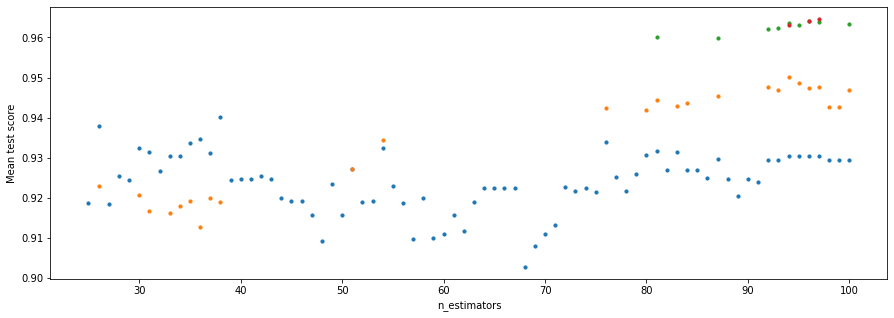

In [45]:
show_cv_results('n_estimators', clf_ada.cv_results_)

In [46]:
best_ada = clf_ada.best_estimator_
best_ada

AdaBoostClassifier(n_estimators=97, random_state=42)

In [47]:
y_val_pred_best_ada = best_ada.predict(X_val)
f2_score(y_val, y_val_pred_best_ada)

0.5701754385964912

# Gradient Boosting

## Setting up parameter grid and Gradient Boosting

In [48]:
n_estimators_gb = np.arange(50, 201, dtype=int)
n_estimators_gb

array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200])

In [49]:
param_grid_gb = {'n_estimators': n_estimators_gb}

In [50]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb

GradientBoostingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [51]:
clf_gb = HalvingGridSearchCV(gb, param_grid_gb, scoring=f2_scorer, cv=3)
clf_gb

HalvingGridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121...24, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200])},
                    scoring=make_scorer

In [52]:
clf_gb.fit(X_train_over, y_train_over)

HalvingGridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121...24, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200])},
                    scoring=make_scorer

In [53]:
clf_gb.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 4, 4]),
 'mean_fit_time': array([ 0.10875416,  0.10537616,  0.1091907 ,  0.12151957,  0.11618694,
         0.1164488 ,  0.11899106,  0.11802157,  0.12168757,  0.12659844,
         0.12341936,  0.12485139,  0.12592713,  0.13184333

,iter,n_estimators,mean_test_score,rank_test_score
0,0,50,0.878932,129
1,0,51,0.878932,129
2,0,52,0.878932,129
3,0,53,0.878932,129
4,0,54,0.878932,129
...,...,...,...,...
222,3,171,0.970474,3
223,3,170,0.970364,4
224,3,163,0.970024,6
225,4,170,0.981715,1


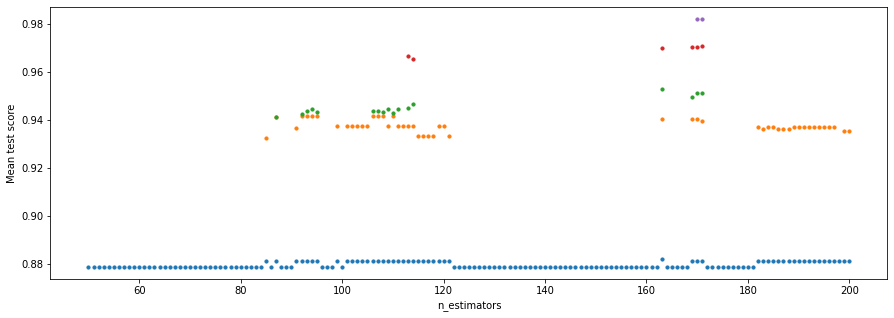

In [54]:
show_cv_results('n_estimators', clf_gb.cv_results_)

In [55]:
best_gb = clf_gb.best_estimator_
best_gb

GradientBoostingClassifier(n_estimators=170, random_state=42)

In [56]:
y_val_pred_best_gb = best_gb.predict(X_val)
f2_score(y_val, y_val_pred_best_gb)

0.7017543859649122

# Voting

In [57]:
estimators = [('rf', best_rf),
              ('bagging', best_bagging),
              ('ada', best_ada),
              ('gb', best_gb)]

In [58]:
voting = VotingClassifier(estimators)
voting

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=157,
                                                     random_state=42)),
                             ('bagging',
                              BaggingClassifier(n_estimators=17,
                                                random_state=42)),
                             ('ada',
                              AdaBoostClassifier(n_estimators=97,
                                                 random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=170,
                                                         random_state=42))])

In [59]:
voting.fit(X_train_val_over, y_train_val_over)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=157,
                                                     random_state=42)),
                             ('bagging',
                              BaggingClassifier(n_estimators=17,
                                                random_state=42)),
                             ('ada',
                              AdaBoostClassifier(n_estimators=97,
                                                 random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=170,
                                                         random_state=42))])

In [60]:
y_test_pred_voting = voting.predict(X_test)
f2_score(y_test, y_test_pred_voting)

0.6168831168831169

# Information

## Notebook approximated execution time

In [61]:
end_time = time.time()
running_time = end_time - start_time
print(f'Time in seconds             {running_time}')
print(f'Time in hour:minute:second  \
{str(datetime.timedelta(seconds=running_time))}')

Time in seconds             1780.4636361598969
Time in hour:minute:second  0:29:40.463636


## Versions

In [62]:
!python --version

Python 3.7.13


In [63]:
np.__version__

'1.21.6'

In [64]:
pd.__version__

'1.3.5'

In [65]:
matplotlib.__version__

'3.2.2'

In [66]:
sklearn.__version__

'1.0.2'

In [67]:
imblearn.__version__

'0.8.1'

## Hardware specifications

In [68]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   39G   70G  36% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  812M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1        81G   43G   39G  53% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  5.7G  9.4G  38% /content/drive


In [69]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.216
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.43
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [70]:
!cat /proc/meminfo

MemTotal:       13298572 kB
MemFree:         9537728 kB
MemAvailable:   11681248 kB
Buffers:          115604 kB
Cached:          2058516 kB
SwapCached:            0 kB
Active:          1897456 kB
Inactive:        1648516 kB
Active(anon):    1205896 kB
Inactive(anon):      452 kB
Active(file):     691560 kB
Inactive(file):  1648064 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               980 kB
Writeback:             0 kB
AnonPages:       1371856 kB
Mapped:           316540 kB
Shmem:              1204 kB
KReclaimable:      90952 kB
Slab:             136304 kB
SReclaimable:      90952 kB
SUnreclaim:        45352 kB
KernelStack:        5936 kB
PageTables:        19468 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649284 kB
Committed_AS:    3977584 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        8440 kB
VmallocChunk:          0 kB
Percpu:          